<div align="center"> 

**hopa1029, klfl1012**

<img src="s_purple.png" alt="drawing" width="2000" height= 200/>


<div align="left">

# Übungsblatt 2 - Personalabteilung
__________________________________________________________________________________________________________________________________________________________________________________________________________________

**DSCB310 – Datenanalyse und Business Intelligence 1**  

Wintersemester 22/23

##### Gliederung des Notebooks:

1. Ziel der Datenanaylse für die Personalabteilung
   
2. Fragestellungen:

   - P1: Prüfen Sie, ob ein Zusammenhang zwischen dem Trinkgeldgeben und dem Vorhandensein eines der folgenden Produkte in einer Bestellung existiert: 24852, 24964, 2120
  
   - P2: Lassen sich regionale Unterschiede im Trinkgeldverhalten erkennen?
  
   - P3: Welche Attribute einer Bestellung wirken sich auf das Trinkgeldverhalten aus?
  
   - P4: Spielt die Vergangenheit eines Users eine Rolle in Hinblick auf die Trinkgeldwahrscheinlichkeit, oder kommt es nur auf Inhalt und Parameter der aktuellen Bestellung an?
  
3. Zusätzliche Fragestellungen

##### Imports und Datensatz: 

**Imports:**

In [136]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

**Datensatz:**

-- erklärung der einzelnen attribute --

In [3]:
df = pd.read_parquet("DSCB310 - UE2 - Shopping Carts.parquet")

In [6]:
df.reset_index(drop= True).head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,tip,product_name,aisle_id,department_id,department,aisle,county
0,1,13176,6,0,112108,4,4,10,9.0,1,Bag of Organic Bananas,24,4,produce,fresh fruits,Inyo
1,1,11109,2,1,112108,4,4,10,9.0,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses,Inyo
2,1,10246,3,0,112108,4,4,10,9.0,1,Organic Celery Hearts,83,4,produce,fresh vegetables,Inyo
3,1,22035,8,1,112108,4,4,10,9.0,1,Organic Whole String Cheese,21,16,dairy eggs,packaged cheese,Inyo
4,1,49683,4,0,112108,4,4,10,9.0,1,Cucumber Kirby,83,4,produce,fresh vegetables,Inyo


In [137]:
def print_evaluation(pipeline_or_model: str, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    accurary_train = accuracy_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)

    accurary_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    
    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'ACC':>10} | {'REC':>14} | {'PRE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {accurary_train:10.5f} | {recall_train:14.5f} | {precision_train:10.5f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {accurary_test:10.5f} | {recall_test:14.5f} | {precision_test:10.5f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )

## 1. Ziel der Datenanalyse für die Personalabteilung:

- Nachvollziehbare und systematische Muster bei der Trinkgeldvergabe finden
- Wovon die Wahrscheinlichkeit, bei einer Bestellung Trinkgeld zu erhalten, abhängt

-> Damit die Chancengleichheit der Fahrer verbessert wird, indem sie entweder vom Unternehmen extra entlohnt werden oder die vielversprechenden und weniger aussichtsreichen Fahrten gleichmäßig auf die Fahrer verteilt werden können.

## 2. Fragestellungen:

### **P1:** Prüfen Sie, ob ein Zusammenhang zwischen dem Trinkgeldgeben und dem Vorhandensein eines der folgenden Produkte in einer Bestellung existiert: 24852, 24964, 2120:

In [139]:
df_tip = df.copy()

In [88]:
df_tip.loc[df_tip.product_id.isin([24852, 24964, 2120])].product_name.unique()

array(['Organic Garlic', 'Banana', 'Sauvignon Blanc'], dtype=object)

##### Bestellungen mit Organic Garlic

In [ ]:
df_tip_1 = df.copy()

In [141]:
df_tip_1["p1_products_in_order"] = 0
df_tip_1.loc[df_tip_1.product_id.isin([24852]), "p1_products_in_order"] = 1

**Bestellungen die das Produkt Organic Garlic enthalten haben eine höhere Wahrscheinlichkeit einen Tipp zu erhalten**  

In [142]:
pd.crosstab(df_tip_1.p1_products_in_order, df.tip, margins= True, normalize= "index")

tip,0,1
p1_products_in_order,,
0,0.553860,0.446140
1,0.460500,0.539500
All,0.552504,0.447496


**Testen ob Unabhängig / Abhängig:**

- H0: (Nullhypothese) Die beiden Variablen sind unabhängig.
- H1: (alternative Hypothese) Die beiden Variablen sind nicht unabhängig.

In [143]:
pd.crosstab(df_tip_1.p1_products_in_order, df.tip, margins= True)

tip,0,1,All
p1_products_in_order,,,
0,3347279,2696263,6043542
1,41043,48084,89127
All,3388322,2744347,6132669


In [ ]:
import scipy.stats as stats

data = pd.crosstab(df_tip_1.p1_products_in_order, df.tip)

stats.chi2_contingency(data)

(3095.9790391918004,
 0.0,
 1,
 array([[3339079.00728443, 2704462.99271557],
        [  49242.99271557,   39884.00728443]]))

Da der p-Wert des Tests weniger als 0.05 beträgt wird die Nullhypothese abgelehnt, es gilt H1.

In [145]:
pd.crosstab(df_tip_1.p1_products_in_order, df.tip, margins= True, normalize= "all")

tip,0,1,All
p1_products_in_order,,,
0,0.545811,0.439656,0.985467
1,0.006693,0.007841,0.014533
All,0.552504,0.447496,1.000000


In [147]:
# hji = hi * hj
pd.crosstab(df_tip_1.p1_products_in_order, df.tip, margins= True, normalize= "all").iloc[1, 1:2].values[0] == 0.006693 * 	0.007841

False

##### Bestellungen mit Banana

In [ ]:
df_tip_2 = df.copy()

In [148]:
df_tip_2["p1_products_in_order"] = 0
df_tip_2.loc[df_tip_2.product_id.isin([24852, 24964, 2120]), "p1_products_in_order"] = 1

**Bestellungen die das Produkt Banana enthalten haben eine höhere Wahrscheinlichkeit einen Tipp zu erhalten**  

In [149]:
pd.crosstab(df_tip_2.p1_products_in_order, df.tip, margins= True, normalize= "index")

tip,0,1
p1_products_in_order,,
0,0.553872,0.446128
1,0.478357,0.521643
All,0.552504,0.447496


**Testen ob Unabhängig / Abhängig:**

- H0: (Nullhypothese) Die beiden Variablen sind unabhängig.
- H1: (alternative Hypothese) Die beiden Variablen sind nicht unabhängig.

In [150]:
pd.crosstab(df_tip_2.p1_products_in_order, df.tip, margins= True)

tip,0,1,All
p1_products_in_order,,,
0,3335155,2686369,6021524
1,53167,57978,111145
All,3388322,2744347,6132669


In [151]:
import scipy.stats as stats

data = pd.crosstab(df_tip_2.p1_products_in_order, df.tip)

stats.chi2_contingency(data)

(2516.7353829996982,
 0.0,
 1,
 array([[3326913.98194294, 2694610.01805706],
        [  61408.01805706,   49736.98194294]]))

Da der p-Wert des Tests weniger als 0.05 beträgt wird die Nullhypothese abgelehnt, es gilt H1.

In [154]:
pd.crosstab(df_tip_2.p1_products_in_order, df.tip, margins= True, normalize= "all")

tip,0,1,All
p1_products_in_order,,,
0,0.543834,0.438042,0.981877
1,0.008669,0.009454,0.018123
All,0.552504,0.447496,1.000000


In [153]:
# hji = hi * hj
pd.crosstab(df_tip_2.p1_products_in_order, df.tip, margins= True, normalize= "all").iloc[1, 1:2].values[0] == 0.447496 * 0.018123

False

##### Bestellungen mit Sauvignon Blanc

In [ ]:
df_tip_3 = df.copy()

In [155]:
df_tip_3["p1_products_in_order"] = 0
df_tip_3.loc[df_tip_3.product_id.isin([24852, 24964, 2120]), "p1_products_in_order"] = 1

**Bestellungen die das Produkt Sauvignon Blanc enthalten haben eine höhere Wahrscheinlichkeit einen Tipp zu erhalten**  

In [156]:
pd.crosstab(df_tip_3.p1_products_in_order, df.tip, margins= True, normalize= "index")

tip,0,1
p1_products_in_order,,
0,0.553872,0.446128
1,0.478357,0.521643
All,0.552504,0.447496


**Testen ob Unabhängig / Abhängig:**

- H0: (Nullhypothese) Die beiden Variablen sind unabhängig.
- H1: (alternative Hypothese) Die beiden Variablen sind nicht unabhängig.

In [157]:
pd.crosstab(df_tip_3.p1_products_in_order, df.tip, margins= True)

tip,0,1,All
p1_products_in_order,,,
0,3335155,2686369,6021524
1,53167,57978,111145
All,3388322,2744347,6132669


In [158]:
import scipy.stats as stats

data = pd.crosstab(df_tip_3.p1_products_in_order, df.tip)

stats.chi2_contingency(data)

(2516.7353829996982,
 0.0,
 1,
 array([[3326913.98194294, 2694610.01805706],
        [  61408.01805706,   49736.98194294]]))

Da der p-Wert des Tests weniger als 0.05 beträgt wird die Nullhypothese abgelehnt, es gilt H1.

In [159]:
pd.crosstab(df_tip_3.p1_products_in_order, df.tip, margins= True, normalize= "all")

tip,0,1,All
p1_products_in_order,,,
0,0.543834,0.438042,0.981877
1,0.008669,0.009454,0.018123
All,0.552504,0.447496,1.000000


In [160]:
# hji = hi * hj
pd.crosstab(df_tip_3.p1_products_in_order, df.tip, margins= True, normalize= "all").iloc[1, 1:2].values[0] == 0.447496 * 0.018123

False

##### Bestellungen mit Organic Garlic, Banana und Sauvignon Blanc

In [68]:
df_tip["p1_products_in_order"] = 0
df_tip.loc[df_tip.product_id.isin([24852, 24964, 2120]), "p1_products_in_order"] = 1

**Bestellungen die die Produkte Organic Garlic, Banana und Sauvignon Blanc enthalten haben eine höhere Wahrscheinlichkeit einen Tipp zu erhalten**  

In [69]:
pd.crosstab(df_tip.p1_products_in_order, df.tip, margins= True, normalize= "index")

tip,0,1
p1_products_in_order,,
0,0.553872,0.446128
1,0.478357,0.521643
All,0.552504,0.447496


**Testen ob Unabhängig / Abhängig:**

- H0: (Nullhypothese) Die beiden Variablen sind unabhängig.
- H1: (alternative Hypothese) Die beiden Variablen sind nicht unabhängig.

In [ ]:
pd.crosstab(df_tip.p1_products_in_order, df.tip, margins= True)

tip,0,1,All
p1_products_in_order,,,
0,3335155,2686369,6021524
1,53167,57978,111145
All,3388322,2744347,6132669


In [ ]:
import scipy.stats as stats

data = pd.crosstab(df_tip.p1_products_in_order, df.tip)

stats.chi2_contingency(data)

(2516.7353829996982,
 0.0,
 1,
 array([[3326913.98194294, 2694610.01805706],
        [  61408.01805706,   49736.98194294]]))

Da der p-Wert des Tests weniger als 0.05 beträgt wird die Nullhypothese abgelehnt, es gilt H1.

In [ ]:
pd.crosstab(df_tip.p1_products_in_order, df.tip, margins= True, normalize= "all")

tip,0,1,All
p1_products_in_order,,,
0,0.543834,0.438042,0.981877
1,0.008669,0.009454,0.018123
All,0.552504,0.447496,1.000000


In [79]:
# hji = hi * hj
pd.crosstab(df_tip.p1_products_in_order, df.tip, margins= True, normalize= "all").iloc[1, 1:2].values[0] == 0.447496 * 0.018123

False

0.447496 * 0.018123 = 0.00811 != 0.009454

**Dadurch ist gezeigt, dass die Tippwahrscheinlichkeit der Bestellungen davon abhängig ist, ob sie die Produkte: Organic Garlic, Banana und Sauvignon Blanc enthält.**  
**Die Bestelungen die die Produkte enthalten, erhalten statistisch gesehen mehr Trinkgeld.** 



### **P2:** Lassen sich regionale Unterschiede im Trinkgeldverhalten erkennen?

In [7]:
df_p2 = df.copy()

**Durchschnittliche Wahrscheinlichkeit das eine Bestellung Trinkgeld erhält, pro County berechnet:**

In [8]:
df_county_tip1 = df_p2.groupby(["county", "order_id"]).agg(tip = ("tip", "mean")).reset_index()
df_county_tip2 = df_county_tip1.groupby("county").agg(tip = ("tip", "mean"), orders= ("order_id", "count")).sort_values(by= "tip", ascending= False).reset_index()
df_county_tip2["orders"] = (df_county_tip2.orders / df_county_tip2.orders.sum())

In [12]:
df_county_tip2.head(10)

,county,tip,orders
0,San Diego,0.530895,0.003920
1,Santa Barbara,0.507548,0.023030
2,Lassen,0.502494,0.003964
3,Del Norte,0.501239,0.003323
4,Modoc,0.492131,0.015599
5,Tuolumne,0.483859,0.004287
6,San Benito,0.475038,0.012046
7,Shasta,0.466202,0.006143
8,El Dorado,0.465879,0.002511
9,San Francisco,0.462101,0.021173


**Plotten der Tippwahrscheinlichkeit pro County:**

In [135]:
# Plot P3: Tippwahrscheinlichkeit pro County

fig1 = make_subplots(cols= 1, rows= 2, shared_xaxes= True, shared_yaxes= False, vertical_spacing= 0)

for county in df_county_tip2.county:

 if df_county_tip2[df_county_tip2.county == county].tip.values >= 0.5:
  color = px.colors.sequential.Purpor[5]
  text= df_county_tip2.loc[df_county_tip2.county == county].tip.values.round(3)

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].tip,
    name= f"{county}: {(df_county_tip2.loc[df_county_tip2.county == county].tip.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    text= text,
    base= 0,
    legendgroup= f"{county}" 
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].orders,
    name= f"Orders: {(df_county_tip2.loc[df_county_tip2.county == county].orders.values[0] * 100).round(3)}%",
    base = -df_county_tip2.loc[df_county_tip2.county == county].orders,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{county}"
   ),
   col= 1,
   row= 2
  )

 elif 0.4 < df_county_tip2.loc[df_county_tip2.county == county].tip.values < 0.5:
  color= px.colors.sequential.Greys[3]

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].tip,
    name= f"{county}: {(df_county_tip2.loc[df_county_tip2.county == county].tip.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{county}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].orders,
    name= f"Orders: {(df_county_tip2.loc[df_county_tip2.county == county].orders.values[0] * 100).round(3)}%",
    base = -df_county_tip2.loc[df_county_tip2.county == county].orders,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{county}"
   ),
   col= 1,
   row= 2
  )

 elif 0.3 < df_county_tip2.loc[df_county_tip2.county == county].tip.values < 0.4:
  color= px.colors.sequential.Greys[2]

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].tip,
    name= f"{county}: {(df_county_tip2.loc[df_county_tip2.county == county].tip.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{county}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].orders,
    name= f"Orders: {(df_county_tip2.loc[df_county_tip2.county == county].orders.values[0] * 100).round(3)}%",
    base = -df_county_tip2.loc[df_county_tip2.county == county].orders,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{county}"
   ),
   col= 1,
   row= 2
  )

 elif 0.2 < df_county_tip2.loc[df_county_tip2.county == county].tip.values < 0.3:
  color= px.colors.sequential.Greys[1]
  text= df_county_tip2.loc[df_county_tip2.county == county].tip.values.round(3)

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].tip,
    name= f"{county}: {(df_county_tip2.loc[df_county_tip2.county == county].tip.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    text= text,
    base= 0,
    legendgroup= f"{county}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_county_tip2.loc[df_county_tip2.county == county].county,
    y= df_county_tip2.loc[df_county_tip2.county == county].orders,
    name= f"Orders: {(df_county_tip2.loc[df_county_tip2.county == county].orders.values[0] * 100).round(3)}%",
    base = -df_county_tip2.loc[df_county_tip2.county == county].orders,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{county}"
   ),
   col= 1,
   row= 2
  )

fig1.add_hline(
 y= 0.5,
 opacity= 0.3,
 line_dash= "solid",
 annotation_text= 0.5,
 annotation_position= "top right",
 line_color= px.colors.sequential.Greys[7],
 annotation_font_color= px.colors.sequential.Greys[7],
 annotation_font_size= 12,
 layer= "below",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= 0.3,
 opacity= 0.3,
 line_dash= "solid",
 annotation_text= 0.3,
 annotation_position= "top right",
 line_color= px.colors.sequential.Greys[7],
 annotation_font_color= px.colors.sequential.Greys[7],
 annotation_font_size= 12,
 layer= "below",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= -0.05,
 opacity= 0.3,
 line_dash= "solid",
 annotation_text= -0.05,
 annotation_position= "top right",
 line_color= px.colors.sequential.Greys[7],
 annotation_font_color= px.colors.sequential.Greys[7],
 annotation_font_size= 12,
 layer= "below",
 col= 1,
 row= 2
)

fig1.add_hline(
 y= -0.03,
 opacity= 0.3,
 line_dash= "solid",
 annotation_text= -0.03,
 annotation_position= "top right",
 line_color= px.colors.sequential.Greys[7],
 annotation_font_color= px.colors.sequential.Greys[7],
 annotation_font_size= 12,
 layer= "below",
 col= 1,
 row= 2
)

fig1.add_hline(
 y= 0,
 opacity= 0.2,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= 0,
 opacity= 0.2,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 layer= "below",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 layer= "below",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= -0.075,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.update_annotations(opacity= 0.8)
fig1.update_layout(title= dict(text= "<b>Regionale Unterschiede im Trinkgeldverhalten</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475), legend_title_text = "<b>Counties</b>", height= 700)
fig1.update_xaxes(title_text="<b>Counties</b>", ticks= "outside", col= 1, row= 2, showline= True)
fig1.update_xaxes(showline= False, col= 1, row= 1)
fig1.update_yaxes(title_text="<b>Tipp Wshk.</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 1, tickvals= [0, 0.1, 0.2, 0.3, 0.4, 0.5], showline= False)
fig1.update_yaxes(title_text="<b>Order Anteil</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 2, tickvals= [0, -0.01, -0.03, -0.05, -0.07])
fig1.update_layout(plot_bgcolor= "white", xaxis= dict(linecolor= "black"), yaxis= dict(linecolor= "black"))
fig1.show()

### **P3:** Welche Attribute einer Bestellung wirken sich auf das Trinkgeldverhalten aus?

In [91]:
df_p3 = df.copy()

#### Korrelation

#### Machine Learning Modell und Feature Importance:

##### Preprocessing

In [ ]:
df_ml = df_p3.reset_index(drop= True)
df_ml = df_p3.fillna(0)

In [ ]:
df_sample = df_ml.sample(frac= 0.1)

In [ ]:
df_tip = df_sample.groupby(["user_id", "order_id", "order_number"], as_index= False).agg(tip = ("tip", "mean")).sort_values(by= ["user_id", "order_number"], ascending= True)
df_tip["tip_cumsum"] = df_tip.groupby("user_id", as_index= False)["tip"].cumsum()
df_tip["user_tip_ratio"] = df_tip.tip_cumsum / df_tip.order_number

df_tip_merge = df_tip[["user_id", "order_id", "order_number", "user_tip_ratio"]]
df_sample = df_sample.merge(df_tip_merge, on = ["user_id", "order_id", "order_number"], how= "right")

In [ ]:
df_classifier = df_sample.copy()

In [ ]:
df_classifier = pd.get_dummies(df_classifier, columns= ["county"])

In [ ]:
X = df_classifier.drop(["product_name", "department", "aisle", "tip"], axis= 1)
y = df_classifier["tip"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

##### **HGBC**

In [ ]:
gs_crss_hgbc = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1,3,5,9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_hgbc.best_params_} with acc: {gs_crss_hgbc.best_score_}")

Best param: {'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100, 'random_state': 0} with acc: 0.6352012738010956


In [ ]:
best_hgbc = HistGradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, max_iter= 100, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_hgbc.predict(X_train)
y_best_test_pred = best_hgbc.predict(X_test)

print_evaluation("HGBC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

HGBC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.63496 |        0.47595 |    0.62052 |   490613 |       68
Test      0.63202 |        0.46920 |    0.61693 |   122654 |       68



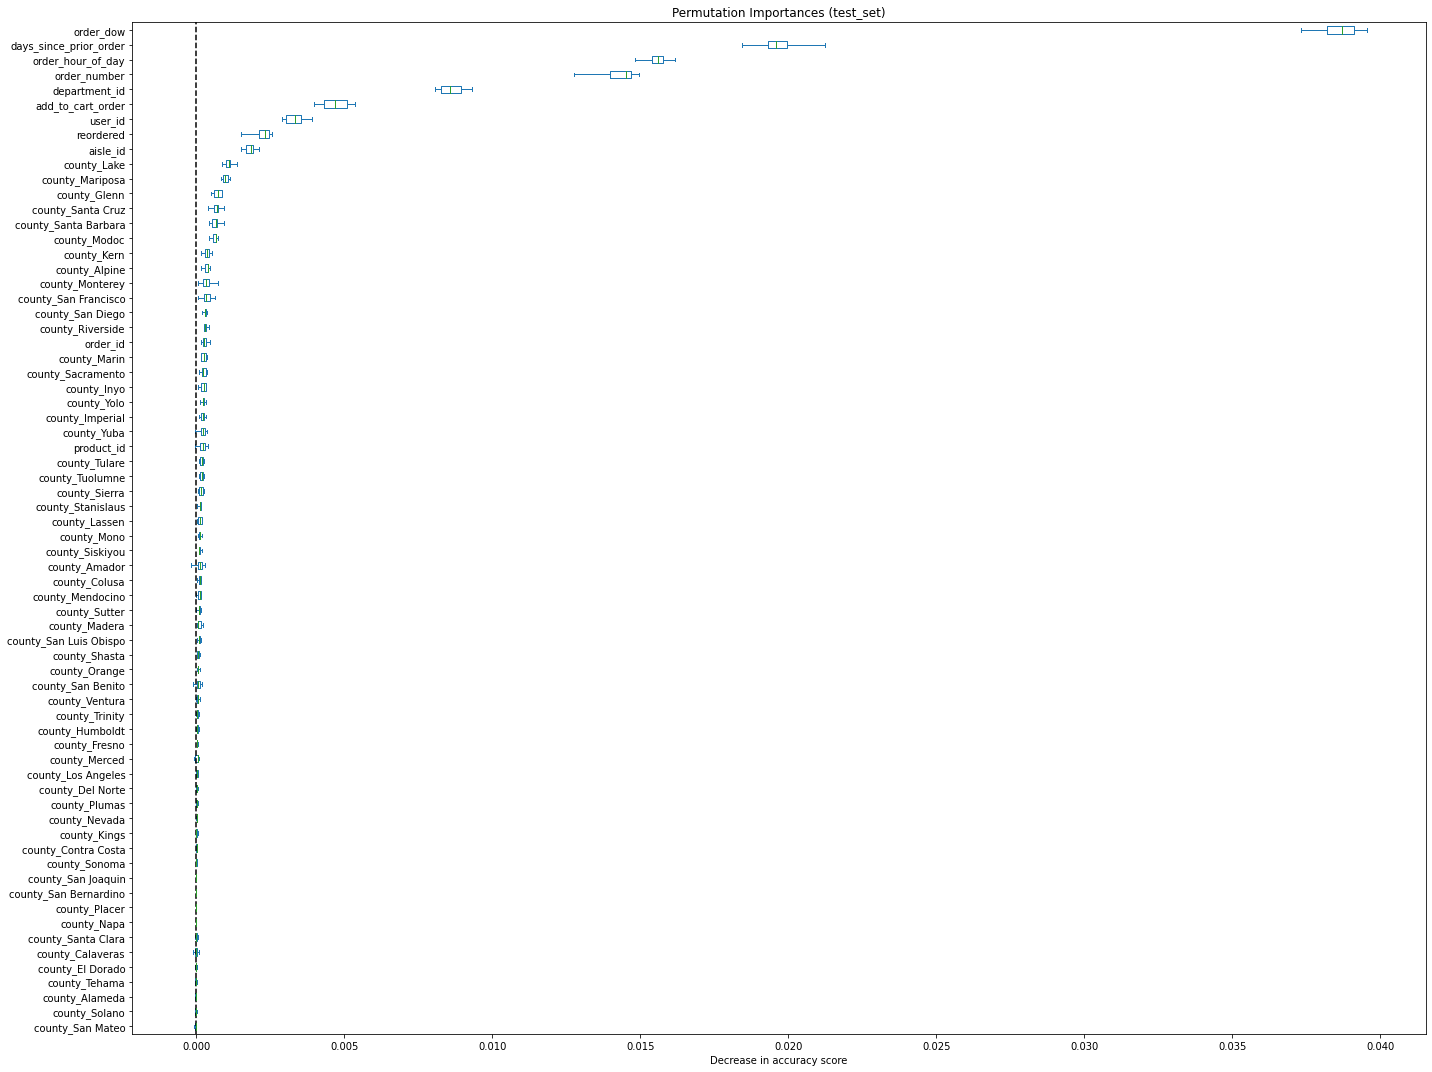

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_hgbc, X_test, y_test, n_repeats= 10, random_state= 0, n_jobs= -1)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
 result.importances[sorted_importances_idx].T,
 columns= X.columns[sorted_importances_idx]
)

ax= importances.plot.box(vert= False, whis= 10, figsize= (20, 15))
ax.set_title("Permutation Importances (test_set)")
ax.axvline(x= 0, color= "k", linestyle= "--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

##### **DTC**

In [ ]:
gs_crss_dtc = GridSearchCV(
 estimator= DecisionTreeClassifier(),
 param_grid= dict(min_samples_split= [2, 10, 20, 50, 100], max_depth= [1, 3, 5, 9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_dtc.best_params_} with acc: {gs_crss_dtc.best_score_}")

Best param: {'max_depth': 9, 'min_samples_split': 2, 'random_state': 0} with acc: 0.6153791267999122


In [ ]:
best_dtc = DecisionTreeClassifier(max_depth= 9, min_samples_split= 2, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_dtc.predict(X_train)
y_best_test_pred = best_dtc.predict(X_test)

print_evaluation("DTC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

DTC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.62265 |        0.44900 |    0.60626 |   490613 |       68
Test      0.61832 |        0.44142 |    0.60009 |   122654 |       68



In [ ]:
print(dict(zip(X.columns, best_dtc.feature_importances_)))

{'order_id': 0.019581176205294853, 'product_id': 0.002537565071532999, 'add_to_cart_order': 0.022761942309562227, 'reordered': 0.006659065878254095, 'user_id': 0.02214895472079787, 'order_number': 0.1447682936353831, 'order_dow': 0.26321289253051317, 'order_hour_of_day': 0.11834175897163453, 'days_since_prior_order': 0.31906231707003263, 'aisle_id': 0.0031052613953845994, 'department_id': 0.04841315012127472, 'county_Alameda': 0.0, 'county_Alpine': 0.002244993863614482, 'county_Amador': 0.0, 'county_Calaveras': 0.0015117222700695514, 'county_Colusa': 0.0, 'county_Contra Costa': 0.0007651771762174871, 'county_Del Norte': 0.0, 'county_El Dorado': 0.0, 'county_Fresno': 0.000432596391538689, 'county_Glenn': 0.0023329571095769734, 'county_Humboldt': 0.0, 'county_Imperial': 0.0008681458648554431, 'county_Inyo': 0.00020955951935235583, 'county_Kern': 0.0004655911828492815, 'county_Kings': 0.0, 'county_Lake': 0.002773278902561399, 'county_Lassen': 0.0006038669201519709, 'county_Los Angeles': 0

#### Attribut: order_dow

In [92]:
df1 = df_p3.groupby(["order_dow", "order_id"], as_index= False).agg(tip_orders_per_day = ("tip", "mean"))
df1.head()

,order_dow,order_id,tip_orders_per_day
0,0,4,1.0
1,0,6,0.0
2,0,9,1.0
3,0,10,0.0
4,0,19,1.0


In [93]:
df_order_dow= df1.groupby("order_dow", as_index= False).agg(tip = ("tip_orders_per_day","sum"), orders= ("order_id", "nunique"))
df_order_dow["tip_norm"] = df_order_dow.tip / df_order_dow.orders
df_order_dow["orders_norm"] = df_order_dow.orders / df_order_dow.orders.sum()
df_order_dow.head()

,order_dow,tip,orders,tip_norm,orders_norm
0,0,53749.0,106842,0.503070,0.176041
1,1,54928.0,104713,0.524558,0.172533
2,2,30614.0,83177,0.368058,0.137049
3,3,27884.0,77329,0.360589,0.127413
4,4,27780.0,75323,0.368812,0.124108


In [94]:
df_order_dow["order_dow_day"] = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
df_order_dow.head()

,order_dow,tip,orders,tip_norm,orders_norm,order_dow_day
0,0,53749.0,106842,0.503070,0.176041,Montag
1,1,54928.0,104713,0.524558,0.172533,Dienstag
2,2,30614.0,83177,0.368058,0.137049,Mittwoch
3,3,27884.0,77329,0.360589,0.127413,Donnerstag
4,4,27780.0,75323,0.368812,0.124108,Freitag


**Plotten der Tippwahrscheinlichkeit pro Wochentag**

In [124]:
# Plot P3: Order_dow

df_order_dow["tip_norm"] = df_order_dow.tip_norm.round(3)
df_order_dow["orders_norm"] = df_order_dow.orders_norm.round(3)

fig = make_subplots(cols= 1, rows=2, specs= [[dict(type= "table")], [dict(type= "bar")]], vertical_spacing= 0.1)

fig.add_trace(
  go.Table(
    columnorder= [1, 2, 3, 4, 5],
    columnwidth= [1, 1, 1, 1, 1],
    header=dict(
        values=list(df_order_dow.columns),
        fill_color= px.colors.sequential.Purpor[5],
        line_color= px.colors.sequential.Greys[2],
        font= dict(color= "white", size=15),
        height= 35
        ),
    cells=dict(
        values=df_order_dow.T.values,
        fill_color= "white",
        line_color= px.colors.sequential.Greys[2],
        font= dict(color= "black", size=13),
        align= "center",
        height= 30
        )
    ),
    col= 1,
    row= 1
)

for order_dow in df_order_dow.order_dow:

 if df_order_dow[df_order_dow.order_dow == order_dow].tip_norm.values >= 0.5:
  color = px.colors.sequential.Purpor[5]
  text= df_order_dow.loc[df_order_dow.order_dow == order_dow].tip_norm.values.round(3)

  fig.add_trace(
   go.Bar(
    x= df_order_dow.loc[df_order_dow.order_dow == order_dow].order_dow,
    y= df_order_dow.loc[df_order_dow.order_dow == order_dow].tip_norm,
    name= f"Tipp: {(df_order_dow.loc[df_order_dow.order_dow == order_dow].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    text= text,
    base= 0,
    legendgroup= f"{order_dow}",
    legendgrouptitle_text = f"{order_dow}:{df_order_dow.loc[df_order_dow.order_dow == order_dow].order_dow_day.values[0]}" 
   ),
   col= 1,
   row= 2
  )

 else:
  color= px.colors.sequential.Greys[2]

  fig.add_trace(
   go.Bar(
    x= df_order_dow.loc[df_order_dow.order_dow == order_dow].order_dow,
    y= df_order_dow.loc[df_order_dow.order_dow == order_dow].tip_norm,
    name= f"Tipp: {(df_order_dow.loc[df_order_dow.order_dow == order_dow].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{order_dow}",
    legendgrouptitle_text = f"{order_dow}:{df_order_dow.loc[df_order_dow.order_dow == order_dow].order_dow_day.values[0]}" 
   ),
   col= 1,
   row= 2
  )

fig.update_layout(title= dict(text= "<b>Tippwahrscheinlichkeit nach Wochentagen</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475), legend_title_text = "<b>Tage</b>", height= 780)
fig.update_xaxes(title_text="<b>Tage</b>", ticks= "outside", col= 1, row= 2)
fig.update_xaxes(showline= True, col= 1, row= 2)
fig.update_yaxes(title_text="<b>Tipp Wshk.</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 2, showline= True, tickvals= [0.1, 0.3, 0.5])
fig.update_layout(plot_bgcolor= "white", xaxis= dict(linecolor= "black"), yaxis= dict(linecolor= "black"))
fig.show()

#### Attribut: days_since_prior_order

In [109]:
df_days = df_p3.groupby(["days_since_prior_order", "order_id"], as_index=False).agg(tip_mean= ("tip", "mean"))
df_days_since_prior_order= df_days.groupby("days_since_prior_order", as_index= False).agg(tip= ("tip_mean", "sum"), orders= ("order_id", "nunique"))
df_days_since_prior_order["tip_norm"] = df_days_since_prior_order.tip / df_days_since_prior_order.orders
df_days_since_prior_order["orders_norm"] = df_days_since_prior_order.orders / df_days_since_prior_order.orders.sum()
df_days_since_prior_order.head()

,days_since_prior_order,tip,orders,tip_norm,orders_norm
0,0.0,5159.0,12005,0.429738,0.021078
1,1.0,10188.0,26178,0.389182,0.045963
2,2.0,14490.0,34983,0.414201,0.061422
3,3.0,17048.0,38541,0.442334,0.067669
4,4.0,18052.0,39479,0.457256,0.069316


In [115]:
# Plot P3: Days_since_prior_order
fig1 = make_subplots(cols= 1, rows= 2, shared_xaxes= True, shared_yaxes= False, vertical_spacing= 0)

for days_since_prior_order in df_days_since_prior_order.days_since_prior_order:

 if df_days_since_prior_order[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values >= 0.5:
  color = px.colors.sequential.Purpor[5]
  text= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values.round(2)

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm,
    name= f"{int(days_since_prior_order)}: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    text= text,
    base= 0,
    legendgroup= f"{days_since_prior_order}" 
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    name= f"Orders: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm.values[0] * 100).round(3)}%",
    base = -df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{days_since_prior_order}"
   ),
   col= 1,
   row= 2
  )

 elif 0.4 < df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values < 0.5:
  color= px.colors.sequential.Greys[3]

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm,
    name= f"{int(days_since_prior_order)}: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{days_since_prior_order}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    name= f"Orders: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm.values[0] * 100).round(3)}%",
    base = -df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{days_since_prior_order}"
   ),
   col= 1,
   row= 2
  )

 elif 0.3 < df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values < 0.4:
  color= px.colors.sequential.Greys[2]

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm,
    name= f"{int(days_since_prior_order)}: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{days_since_prior_order}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    name= f"Orders: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm.values[0] * 100).round(3)}%",
    base = -df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{days_since_prior_order}"
   ),
   col= 1,
   row= 2
  )

 elif 0.2 < df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values < 0.3:
  color= px.colors.sequential.Greys[1]
  text= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values.round(2)

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm,
    name= f"{int(days_since_prior_order)}: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    text= text,
    base= 0,
    legendgroup= f"{days_since_prior_order}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].days_since_prior_order,
    y= df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    name= f"Orders: {(df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm.values[0] * 100).round(3)}%",
    base = -df_days_since_prior_order.loc[df_days_since_prior_order.days_since_prior_order == days_since_prior_order].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{days_since_prior_order}"
   ),
   col= 1,
   row= 2
  )


fig1.add_hline(
 y= 0,
 opacity= 0.3,
 line_dash= "solid",
 line_color= "grey",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= 0,
 opacity= 0.3,
 line_dash= "solid",
 line_color= "grey",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= -0.18,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.update_annotations(opacity= 0.8)
fig1.update_layout(title= dict(text= "<b>Tippwahrscheinlichkeit von Bestellungen mit Tagen seit der letzten Bestellungen</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475), legend_title_text = "<b>Tage</b>", height= 700)
fig1.update_xaxes(title_text="<b>Tage</b>", ticks= "outside", col= 1, row= 2)
fig1.update_xaxes(showline= False, col= 1, row= 1)
fig1.update_yaxes(title_text="<b>Tipp Wshk.</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 1, showline= False)
fig1.update_yaxes(title_text="<b>Order Anteil</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 2)
fig1.update_layout(plot_bgcolor= "white", xaxis= dict(linecolor= "black"), yaxis= dict(linecolor= "black"))
fig1.show()

#### Attribut: order_hour_of_day

In [117]:
df_h = df_p3.groupby(["order_hour_of_day", "order_id"], as_index= False).agg(tip= ("tip", "mean"))
df_hour = df_h.groupby(["order_hour_of_day"], as_index= False).agg(orders= ("order_id", "nunique"), tip= ("tip", "sum"))
df_hour["tip_norm"] = df_hour.tip / df_hour.orders
df_hour["orders_norm"] = df_hour.orders / df_hour.orders.sum()
df_hour.head()

,order_hour_of_day,orders,tip,tip_norm,orders_norm
0,0,4072,2079.0,0.510560,0.006709
1,1,2219,1125.0,0.506985,0.003656
2,2,1340,694.0,0.517910,0.002208
3,3,956,477.0,0.498954,0.001575
4,4,986,510.0,0.517241,0.001625


**Tippwahrscheinlichkeit pro Stunde:**

In [121]:
# Plot P3: Order_hour_of_day

fig1 = make_subplots(cols= 1, rows= 2, shared_xaxes= True, shared_yaxes= False, vertical_spacing= 0)

for order_hour_of_day in df_hour.order_hour_of_day:

 if df_hour[df_hour.order_hour_of_day == order_hour_of_day].tip_norm.values >= 0.5:
  color = px.colors.sequential.Purpor[5]
  text= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm.values.round(3)

  fig1.add_trace(
   go.Bar(
    x= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].order_hour_of_day,
    y= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm,
    name= f"{order_hour_of_day}: {(df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    text= text,
    base= 0,
    legendgroup= f"{order_hour_of_day}" 
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].order_hour_of_day,
    y= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm,
    name= f"Orders: {(df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm.values[0] * 100).round(3)}%",
    base = -df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{order_hour_of_day}"
   ),
   col= 1,
   row= 2
  )

 elif 0.4 < df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm.values < 0.5:
  color= px.colors.sequential.Greys[3]

  fig1.add_trace(
   go.Bar(
    x= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].order_hour_of_day,
    y= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm,
    name= f"{order_hour_of_day}: {(df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{order_hour_of_day}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].order_hour_of_day,
    y= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm,
    name= f"Orders: {(df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm.values[0] * 100).round(3)}%",
    base = -df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{order_hour_of_day}"
   ),
   col= 1,
   row= 2
  )

 elif 0.3 < df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm.values < 0.4:
  color= px.colors.sequential.Greys[2]

  fig1.add_trace(
   go.Bar(
    x= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].order_hour_of_day,
    y= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm,
    name= f"{order_hour_of_day}: {(df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{order_hour_of_day}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].order_hour_of_day,
    y= df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm,
    name= f"Orders: {(df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm.values[0] * 100).round(3)}%",
    base = -df_hour.loc[df_hour.order_hour_of_day == order_hour_of_day].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{order_hour_of_day}"
   ),
   col= 1,
   row= 2
  )

fig1.add_hline(
 y= 0,
 opacity= 0.3,
 line_dash= "solid",
 line_color= "grey",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= 0,
 opacity= 0.3,
 line_dash= "solid",
 line_color= "grey",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= -0.1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.update_annotations(opacity= 0.8)
fig1.update_layout(title= dict(text= "<b>Tippwahrscheinlichkeit nach Tagesstunden</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475), legend_title_text = "<b>Stunden</b>", height= 700)
fig1.update_xaxes(title_text="<b>Stunden</b>", ticks= "outside", col= 1, row= 2)
fig1.update_xaxes(showline= False, col= 1, row= 1)
fig1.update_yaxes(title_text="<b>Tipp Wshk.</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 1, showline= False)
fig1.update_yaxes(title_text="<b>Order Anteil</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 2, tickvals= [0, -0.025, -0.05, -0.075, -0.1])
fig1.update_layout(plot_bgcolor= "white", xaxis= dict(linecolor= "black"), yaxis= dict(linecolor= "black"))
fig1.show()

#### Attribut: order_number

#### Attribut: department

In [97]:
df_dep = df_p3.groupby(["department", "order_id"], as_index= False).agg(tip_mean= ("tip", "mean"), all= ("order_id", "count"))
df_dep1 = df_dep.groupby("department", as_index= False).agg(tip = ("tip_mean", "sum"), orders= ("order_id", "nunique"))
df_dep1["tip_norm"] = df_dep1.tip / df_dep1.orders
df_dep1["orders_norm"] = df_dep1.orders / df_dep1.orders.sum()
df_dep2 = df_dep1.sort_values(by= "tip_norm", ascending= False)

In [98]:
df_dep2.head()

,department,tip,orders,tip_norm,orders_norm
0,alcohol,12531.0,15569,0.804869,0.005399
4,breakfast,53783.0,100391,0.535735,0.034813
1,babies,17786.0,33891,0.524800,0.011753
5,bulk,3448.0,6618,0.521003,0.002295
20,snacks,133047.0,263766,0.504413,0.091468


In [107]:
# Plot P3: Department

fig1 = make_subplots(cols= 1, rows= 2, shared_xaxes= True, shared_yaxes= False, vertical_spacing= 0)

for department in df_dep2.department:

 if df_dep2[df_dep2.department == department].tip_norm.values >= 0.5:
  color = px.colors.sequential.Purpor[5]
  text= df_dep2.loc[df_dep2.department == department].tip_norm.values.round(3)

  fig1.add_trace(
   go.Bar(
    x= df_dep2.loc[df_dep2.department == department].department,
    y= df_dep2.loc[df_dep2.department == department].tip_norm,
    name= f"{department}: {(df_dep2.loc[df_dep2.department == department].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    text= text,
    base= 0,
    legendgroup= f"{department}" 
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_dep2.loc[df_dep2.department == department].department,
    y= df_dep2.loc[df_dep2.department == department].orders_norm,
    name= f"Orders: {(df_dep2.loc[df_dep2.department == department].orders_norm.values[0] * 100).round(3)}%",
    base = -df_dep2.loc[df_dep2.department == department].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{department}"
   ),
   col= 1,
   row= 2
  )

 elif 0.4 < df_dep2.loc[df_dep2.department == department].tip_norm.values < 0.5:
  color= px.colors.sequential.Greys[3]

  fig1.add_trace(
   go.Bar(
    x= df_dep2.loc[df_dep2.department == department].department,
    y= df_dep2.loc[df_dep2.department == department].tip_norm,
    name= f"{department}: {(df_dep2.loc[df_dep2.department == department].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{department}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_dep2.loc[df_dep2.department == department].department,
    y= df_dep2.loc[df_dep2.department == department].orders_norm,
    name= f"Orders: {(df_dep2.loc[df_dep2.department == department].orders_norm.values[0] * 100).round(3)}%",
    base = -df_dep2.loc[df_dep2.department == department].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{department}"
   ),
   col= 1,
   row= 2
  )

 elif 0.3 < df_dep2.loc[df_dep2.department == department].tip_norm.values < 0.4:
  color= px.colors.sequential.Greys[2]

  fig1.add_trace(
   go.Bar(
    x= df_dep2.loc[df_dep2.department == department].department,
    y= df_dep2.loc[df_dep2.department == department].tip_norm,
    name= f"{department}: {(df_dep2.loc[df_dep2.department == department].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    base= 0,
    legendgroup= f"{department}"
   ),
   col= 1,
   row= 1
  )

  fig1.add_trace(
   go.Bar(
    x= df_dep2.loc[df_dep2.department == department].department,
    y= df_dep2.loc[df_dep2.department == department].orders_norm,
    name= f"Orders: {(df_dep2.loc[df_dep2.department == department].orders_norm.values[0] * 100).round(3)}%",
    base = -df_dep2.loc[df_dep2.department == department].orders_norm,
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{department}"
   ),
   col= 1,
   row= 2
  )

fig1.add_hline(
 y= 0,
 opacity= 0.3,
 line_dash= "solid",
 line_color= "grey",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= 0,
 opacity= 0.3,
 line_dash= "solid",
 line_color= "grey",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.add_vline(
 x= -1,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 1
)

fig1.add_hline(
 y= -0.18,
 opacity= 0.8,
 line_dash= "solid",
 line_color= "black",
 col= 1,
 row= 2
)

fig1.update_annotations(opacity= 0.8)
fig1.update_layout(title= dict(text= "<b>Tippwahrscheinlichkeit der Departments</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475), legend_title_text = "<b>Counties</b>", height= 700)
fig1.update_xaxes(title_text="<b>Counties</b>", ticks= "outside", col= 1, row= 2)
fig1.update_xaxes(showline= False, col= 1, row= 1)
fig1.update_yaxes(title_text="<b>Tipp Wshk.</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 1, showline= False)
fig1.update_yaxes(title_text="<b>Order Anteil</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 2)
fig1.update_layout(plot_bgcolor= "white", xaxis= dict(linecolor= "black"), yaxis= dict(linecolor= "black"))
fig1.show()

#### Attribut: add_to_cart_order

In [ ]:
df_cart1 = df.groupby(["add_to_cart_order", "order_id"], as_index= False).agg(tip= ("tip","mean"))
df_cart_order = df_cart1.groupby(["add_to_cart_order"], as_index= False).agg(orders= ("order_id", "nunique"), tip= ("tip", "sum"))
df_cart_order["tip_norm"] = df_cart_order.tip / df_cart_order.orders
df_cart_order["orders_norm"] = df_cart_order.orders / df_cart_order.orders.sum()
df_cart_order.head()

,add_to_cart_order,orders,tip,tip_norm,orders_norm
0,1,606915,253377.0,0.417484,9.896425e-02
1,2,577408,243405.0,0.421548,9.415281e-02
2,3,542516,230794.0,0.425414,8.846328e-02
3,4,504004,216434.0,0.429429,8.218347e-02
4,5,462326,200421.0,0.433506,7.538740e-02
...,...,...,...,...,...
140,141,1,0.0,0.000000,1.630611e-07
141,142,1,0.0,0.000000,1.630611e-07
142,143,1,0.0,0.000000,1.630611e-07
143,144,1,0.0,0.000000,1.630611e-07


In [ ]:
cart_bins = [1, 5, 10, 30, 50, 70, 90, 100, 150]
df_cart_order["add_to_cart_order_cut"] = pd.cut(df_cart_order["add_to_cart_order"], bins= cart_bins, include_lowest= True)

In [ ]:
df_cart_order_cut = df_cart_order.groupby(["add_to_cart_order_cut"], as_index= False).agg(tip= ("tip", "sum"), tip_norm= ("tip_norm", "mean"), orders= ("orders", "sum"),)
df_cart_order_cut["orders_norm"] = (df_cart_order_cut.orders / df_cart_order_cut.orders.sum()).round(5)
df_cart_order_cut["tip_norm"] = df_cart_order_cut.tip_norm.round(3)
df_cart_order_cut["add_to_cart_order_cut"] = df_cart_order_cut.add_to_cart_order_cut.astype("str")
df_cart_order_cut

,add_to_cart_order_cut,tip,tip_norm,orders,orders_norm
0,"(0.999, 5.0]",1144431.0,0.425,2693169,0.43915
1,"(5.0, 10.0]",752175.0,0.447,1685931,0.27491
2,"(10.0, 30.0]",802582.0,0.492,1667800,0.27195
3,"(30.0, 50.0]",41982.0,0.528,80470,0.01312
4,"(50.0, 70.0]",2575.0,0.615,4444,0.00072
5,"(70.0, 90.0]",486.0,0.774,633,0.00010
6,"(90.0, 100.0]",94.0,0.724,128,0.00002
7,"(100.0, 150.0]",22.0,0.107,94,0.00002


In [ ]:
# Plot P3: Add_to_card_order 

fig = make_subplots(cols= 1, rows=2, specs= [[dict(type= "table")], [dict(type= "bar")]], vertical_spacing= 0.03)

fig.add_trace(
  go.Table(
    columnorder= [1, 2, 3, 4, 5],
    columnwidth= [1, 1, 1, 1, 1],
    header=dict(
        values= list(df_cart_order_cut.columns),
        fill_color= px.colors.sequential.Purpor[5],
        line_color= px.colors.sequential.Greys[2],
        font= dict(color= "white", size=15),
        height= 35
        ),
    cells=dict(
        values= df_cart_order_cut.T.values,
        fill_color= "white",
        line_color= px.colors.sequential.Greys[2],
        font= dict(color= "black", size=13),
        align= "center",
        height= 30
        )
    ),
    col= 1,
    row= 1
)


for interval in df_cart_order_cut.add_to_cart_order_cut.unique():

 if df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values >= 0.7:
  color = px.colors.sequential.Purpor[5]

  fig.add_trace(
   go.Bar(
    x= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].add_to_cart_order_cut.values,
    y= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )

 elif 0.5 < df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values < 0.7:
  color = px.colors.sequential.Purpor[4]

  fig.add_trace(
   go.Bar(
    x= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].add_to_cart_order_cut.values,
    y= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )


 elif 0.4 < df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values < 0.5:
  color = px.colors.sequential.Greys[3]

  fig.add_trace(
   go.Bar(
    x= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].add_to_cart_order_cut.values,
    y= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )
 else:
  color = px.colors.sequential.Greys[2]

  fig.add_trace(
   go.Bar(
    x= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].add_to_cart_order_cut.values,
    y= df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_cart_order_cut.loc[df_cart_order_cut.add_to_cart_order_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )


fig.update_layout(title= dict(text= "<b>Tippwahrscheinlichkeit Warenkorbplatzierung</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475), legend_title_text = "<b>Intervalle</b>", height= 800)
fig.update_xaxes(title_text="<b>Intervalle</b>", ticks= "outside", col= 1, row= 2, showline= True)
fig.update_yaxes(title_text="<b>Tipp Wshk.</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 2, showline= True, tickvals= [0, 0.25, 0.5, 0.75])
fig.update_layout(plot_bgcolor= "white", xaxis= dict(linecolor= "black"), yaxis= dict(linecolor= "black"))

fig.show()

In [ ]:
df_1 = df.groupby(["order_id"], as_index= False).agg(order_size= ("add_to_cart_order", "max"), tip= ("tip", "mean"))
df_2 = df_1.groupby(["order_size"], as_index= False).agg(tip= ("tip", "sum"), orders= ("order_id", "nunique"))
df_2["tip_norm"] = df_2.tip / df_2.orders
df_2["orders_norm"] = df_2.orders / df_2.orders.sum()
df_2.head()

,order_size,tip,orders,tip_norm,orders_norm
0,1,9972.0,29507,0.337954,0.048618
1,2,12611.0,34892,0.361430,0.057491
2,3,14360.0,38512,0.372871,0.063455
3,4,16013.0,41678,0.384207,0.068672
4,5,16877.0,43199,0.390680,0.071178
...,...,...,...,...,...
95,105,1.0,1,1.000000,0.000002
96,108,1.0,1,1.000000,0.000002
97,109,1.0,1,1.000000,0.000002
98,127,0.0,1,0.000000,0.000002


In [ ]:
ordersize_bins = [1, 5, 10, 30, 50, 70, 90, 100, 150]
df_2["order_size_cut"] = pd.cut(df_2["order_size"], bins= ordersize_bins, include_lowest= True)

In [ ]:
df_2_cut = df_2.groupby(["order_size_cut"], as_index= False).agg(tip= ("tip", "sum"), tip_norm= ("tip_norm", "mean"), orders= ("orders", "sum"),)
df_2_cut["orders_norm"] = (df_2_cut.orders / df_2_cut.orders.sum()).round(5)
df_2_cut["tip_norm"] = df_2_cut.tip_norm.round(3)
df_2_cut["order_size_cut"] = df_2_cut.order_size_cut.astype("str")
df_2_cut

,order_size_cut,tip,tip_norm,orders,orders_norm
0,"(0.999, 5.0]",69833.0,0.369,187788,0.30941
1,"(5.0, 10.0]",77444.0,0.409,189677,0.31253
2,"(10.0, 30.0]",99888.0,0.476,217287,0.35802
3,"(30.0, 50.0]",5891.0,0.518,11573,0.01907
4,"(50.0, 70.0]",285.0,0.533,540,0.00089
5,"(70.0, 90.0]",21.0,0.710,31,0.00005
6,"(90.0, 100.0]",12.0,0.926,14,0.00002
7,"(100.0, 150.0]",3.0,0.600,5,0.00001


In [ ]:
# Plot P3: Order_size

fig = make_subplots(cols= 1, rows=2, specs= [[dict(type= "table")], [dict(type= "bar")]], vertical_spacing= 0.03)

fig.add_trace(
  go.Table(
    columnorder= [1, 2, 3, 4, 5],
    columnwidth= [1, 1, 1, 1, 1],
    header=dict(
        values= list(df_2_cut.columns),
        fill_color= px.colors.sequential.Purpor[5],
        line_color= px.colors.sequential.Greys[2],
        font= dict(color= "white", size=15),
        height= 35
        ),
    cells=dict(
        values= df_2_cut.T.values,
        fill_color= "white",
        line_color= px.colors.sequential.Greys[2],
        font= dict(color= "black", size=13),
        align= "center",
        height= 30
        )
    ),
    col= 1,
    row= 1
)


for interval in df_2_cut.order_size_cut.unique():

 if df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values >= 0.7:
  color = px.colors.sequential.Purpor[5]

  fig.add_trace(
   go.Bar(
    x= df_2_cut.loc[df_2_cut.order_size_cut == interval].order_size_cut.values,
    y= df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )

 elif 0.5 < df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values < 0.7:
  color = px.colors.sequential.Purpor[4]

  fig.add_trace(
   go.Bar(
    x= df_2_cut.loc[df_2_cut.order_size_cut == interval].order_size_cut.values,
    y= df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )


 elif 0.4 < df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values < 0.5:
  color = px.colors.sequential.Greys[3]

  fig.add_trace(
   go.Bar(
    x= df_2_cut.loc[df_2_cut.order_size_cut == interval].order_size_cut.values,
    y= df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )
 else:
  color = px.colors.sequential.Greys[2]

  fig.add_trace(
   go.Bar(
    x= df_2_cut.loc[df_2_cut.order_size_cut == interval].order_size_cut.values,
    y= df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values,
    name= f"{interval}: {(df_2_cut.loc[df_2_cut.order_size_cut == interval].tip_norm.values[0] * 100).round(2)}%",
    showlegend= True,
    marker= dict(color= color),
    width= 0.8,
    legendgroup= f"{interval}",
    hovertemplate = f"<b>{interval}</b><br><br>" +
        "Tipp: %{y:.0%}<br>" +
        "<extra></extra>",
   ),
  )


fig.update_layout(title= dict(text= "<b>Tippwahrscheinlichkeit Bestellungsgröße</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475), legend_title_text = "<b>Intervalle</b>", height= 800)
fig.update_xaxes(title_text="<b>Intervalle</b>", ticks= "outside", col= 1, row= 2, showline= True)
fig.update_yaxes(title_text="<b>Tipp Wshk.</b>", ticks= "outside", showgrid= True, gridcolor= "grey", col= 1, row= 2, showline= True, tickvals= [0, 0.25, 0.5, 0.75])
fig.update_layout(plot_bgcolor= "white", xaxis= dict(linecolor= "black"), yaxis= dict(linecolor= "black"))

fig.show()

### **P4:** Spielt die Vergangenheit eines Users eine Rolle in Hinblick auf die Trinkgeldwahrscheinlichkeit, oder kommt es nur auf Inhalt und Parameter der aktuellen Bestellung an?

##### Preprocessing

In [21]:
df_user_hist = df.copy()

In [22]:
df_user_hist = df_user_hist.sort_values(by= ["user_id", "order_number"], ascending= True)
df_user = df_user_hist.groupby("user_id", as_index= False).agg(orders = ("order_id", "unique"), reordered= ("reordered", "mean"), tip= ("tip", "mean"), order_number= ("order_number", "unique"))
df_user.head()

,user_id,orders,reordered,tip,order_number
0,3,"[244029, 78693, 533119, 361761, 481466, 350475...",0.625000,0.840909,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
1,7,"[455863, 426645, 21397, 301146, 589317, 298684...",0.679070,0.637209,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,14,"[515987, 569030, 242632, 245955, 300451, 37770...",0.343891,0.506787,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
3,23,"[318279, 1415, 337923, 190237, 603547]",0.192308,0.000000,"[1, 2, 3, 4, 5]"
4,25,"[463866, 531613, 45667]",0.095238,0.476190,"[1, 2, 3]"


In [23]:
last_orders = []

for ind, order in enumerate(df_user.orders):
 last_orders.append(df_user.orders[ind][-1])

df_user_hist.drop(df_user_hist.loc[df_user_hist.order_id.isin(last_orders)].index, inplace= True)

In [24]:
df_userh = df_user_hist.groupby("user_id", as_index= False).agg(orders = ("order_id", "nunique"), reordered= ("reordered", "mean"), tip= ("tip", "mean"))
df_userh.head()

,user_id,orders,reordered,tip
0,3,11,0.597561,0.829268
1,7,20,0.669903,0.621359
2,14,13,0.323810,0.533333
3,23,4,0.100000,0.000000
4,25,2,0.066667,0.266667


In [25]:
df_last_order = df.loc[df.order_id.isin(last_orders)].groupby("user_id").agg(tip_last_order= ("tip", "max"), last_order_id = ("order_id", "max")).reset_index()
df_last_order.head()

,user_id,tip_last_order,last_order_id
0,3,1,248921
1,7,1,93090
2,14,0,411382
3,23,0,603547
4,25,1,45667


In [26]:
df_userh = df_userh.merge(df_last_order, how= "right", on= "user_id")
df_userh.head()

,user_id,orders,reordered,tip,tip_last_order,last_order_id
0,3,11,0.597561,0.829268,1,248921
1,7,20,0.669903,0.621359,1,93090
2,14,13,0.323810,0.533333,0,411382
3,23,4,0.100000,0.000000,0,603547
4,25,2,0.066667,0.266667,1,45667


##### Analyse

**Bestellungen bei welcher der user eine tip_wshk von >= 0.5 hat verglichen mit seiner letzten/aktuellen Bestellung**


Unter der Annahme, dass wenn die tip_wshk eines users in der historie >= 0.5 ist, tendiert er eher dazu zu tippen bei seiner letzten/aktuellen Bestellung

**trifft zu:**

In [28]:
df_userh.loc[(df_userh.tip >= 0.5) & (df_userh.tip_last_order == 1)].head()

,user_id,orders,reordered,tip,tip_last_order,last_order_id
0,3,11,0.597561,0.829268,1,248921
1,7,20,0.669903,0.621359,1,93090
6,39,6,0.571429,0.500000,1,489351
13,73,6,0.363636,0.636364,1,443957
15,85,6,0.384615,0.807692,1,431764


In [48]:
case1_true = 7685 / 37367
case1_true

0.2056627505553028

**trifft nicht zu:**

In [29]:
df_userh.loc[(df_userh.tip >= 0.5) & (df_userh.tip_last_order == 0)].head() 

,user_id,orders,reordered,tip,tip_last_order,last_order_id
2,14,13,0.323810,0.533333,0,411382
20,110,20,0.556196,0.700288,0,12722
26,138,32,0.628378,0.533784,0,80767
27,140,76,0.735882,0.537793,0,454907
33,169,6,0.105882,0.917647,0,136338


In [49]:
case1_false = 4181 / 37367
case1_false

0.11189017047127145

**Bestellungen bei welcher der user eine tip_wshk von < 0.5 hat verglichen mit seiner letzten/aktuellen Bestellung**

Unter der Annahme, dass wenn die tip_wshk eines users in der historie < 0.5 ist, tendiert er eher dazu nicht zu tippen bei seiner letzten/aktuellen Bestellung

**trifft zu:**

In [32]:
df_userh.loc[(df_userh.tip < 0.5) & (df_userh.tip_last_order == 0)].head()

,user_id,orders,reordered,tip,tip_last_order,last_order_id
3,23,4,0.100000,0.000000,0,603547
9,53,3,0.028571,0.000000,0,548094
10,55,7,0.505747,0.000000,0,6945
11,65,14,0.393939,0.000000,0,190242
14,83,6,0.333333,0.179487,0,430576


In [50]:
case2_true = 20635 / 37367
case2_true

0.5522252254663206

**trifft nicht zu:**

In [34]:
df_userh.loc[(df_userh.tip < 0.5) & (df_userh.tip_last_order == 1)].head() 

,user_id,orders,reordered,tip,tip_last_order,last_order_id
4,25,2,0.066667,0.266667,1,45667
5,28,23,0.416667,0.303571,1,351338
7,40,8,0.641304,0.456522,1,203217
8,42,16,0.548872,0.127820,1,497941
12,72,12,0.680851,0.212766,1,463486


In [51]:
case2_false = 4866 / 37367
case2_false

0.1302218535071052

In [52]:
print(f"Wahrscheinlichkeit Trifft zu: {case1_true + case2_true}, Wahrscheinlichlkeit Trifft nicht zu: {case1_false + case2_false}")

Wahrscheinlichkeit Trifft zu: 0.7578879760216234, Wahrscheinlichlkeit Trifft nicht zu: 0.24211202397837664


##### Preprocessing und Feature Importance 

Um zu belegen das die Vergangenheit eines Users die Trinkgeldwahrscheinlichkeit seiner aktuellen Bestellung beeinlfusst wird der Dataframe in zwei Datensätze unterteilt.   

Im Ersten sind alle Bestellung der Historie eines Users und im Zweiten befinden sich nur die aktuellen Bestellungen eines Users.  

Der erste Datensatz erhält ein zusätzliches Feature, die user_tip_ratio, welches die Tippwahrscheinlichkeit jedes Users zum Zeitpunkt seiner Bestellung berechnet.    

Auf dem ersten Datensatz wird nun ein Entscheidungsbaum als Classifier trainiert der die Wahrscheinlichkeit, dass eine Bestellung einen Tipp erhält, (tip: 0/1) auf dem zweiten Datensatz (die aktuellen Bestellungen) versucht hervorzusagen. 

In [54]:
# Funktion für die Print-Ausgabe des Classifiers

def print_evaluation(pipeline_or_model: str, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    accurary_train = accuracy_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)

    accurary_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    
    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'ACC':>10} | {'REC':>14} | {'PRE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {accurary_train:10.5f} | {recall_train:14.5f} | {precision_train:10.5f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {accurary_test:10.5f} | {recall_test:14.5f} | {precision_test:10.5f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )

In [56]:
df_userhh = df.copy()
df_userhh = df_userhh.sort_values(by= ["user_id", "order_number"], ascending= True)
df_userh1 = df_userhh.groupby("user_id", as_index= False).agg(orders = ("order_id", "unique"), reordered= ("reordered", "mean"), tip= ("tip", "mean"), order_number= ("order_number", "unique"))

last_orders = []
for ind, order in enumerate(df_userh1.orders):
 last_orders.append(df_userh1.orders[ind][-1])

df_userhh.drop(df_userhh.loc[df_userhh.order_id.isin(last_orders)].index, inplace= True)
df_userh = df_userhh.groupby("user_id", as_index= False).agg(orders = ("order_id", "nunique"), reordered= ("reordered", "mean"), tip= ("tip", "mean"))
df_last_order = df.loc[df.order_id.isin(last_orders)].groupby("user_id").agg(tip_last_order= ("tip", "max"), last_order_id = ("order_id", "max")).reset_index()

In [58]:
df1 = df.copy()
df_last_orders = df1.loc[df1.order_id.isin(last_orders)]
df1.drop(df1.loc[df1.order_id.isin(last_orders)].index, inplace= True)
df_tip = df1.groupby(["user_id"], as_index= False).agg(user_tip_ratio = ("tip", "mean"))
df1 = df1.merge(df_tip, on= "user_id", how= "right")
df_last_orders = df_last_orders.merge(df_tip, on= "user_id", how= "right")

##### Entscheidungsbaum und Feature Importance

In [64]:
X = df1[["order_id",	"product_id",	"add_to_cart_order",	"user_id",	"order_number",	"order_dow",	"order_hour_of_day",	"days_since_prior_order",	"aisle_id",	"department_id", "user_tip_ratio"]]
y = df1["tip"]

In [65]:
X_train, y_train = X , y

In [66]:
X_test, y_test = df_last_orders[["order_id",	"product_id",	"add_to_cart_order",	"user_id",	"order_number",	"order_dow",	"order_hour_of_day",	"days_since_prior_order",	"aisle_id",	"department_id", "user_tip_ratio"]], df_last_orders["tip"]

In [ ]:
gs_crossv = GridSearchCV(
 estimator= DecisionTreeClassifier(),
 param_grid= dict(min_samples_split= [2, 10, 20, 50, 100], max_depth= [1, 3, 6, 9], random_state= [0]),
 scoring = "accuracy",
 n_jobs= -1,
 cv= 5
).fit(X_train, y_train)

print(f"Best parameters: {gs_crossv.best_params_}, with score: {gs_crossv.best_score_}")

Best parameters: {'max_depth': 6, 'min_samples_split': 2, 'random_state': 0}, with score: 0.7724332017517882


In [ ]:
dtc2 = DecisionTreeClassifier(min_samples_split= 2, max_depth= 6, random_state= 0).fit(X_train, y_train)

y_pred_train_best_dtc2 = dtc2.predict(X_train)
y_pred_test_best_dtc2 = dtc2.predict(X_test)

print_evaluation("DTC", X_train, X_test, y_train, y_test, y_pred_train_best_dtc2, y_pred_test_best_dtc2)

DTC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.77942 |        0.73144 |    0.77023 |  5740420 |       11
Test      0.76509 |        0.64272 |    0.69115 |   392249 |       11



In [ ]:
print(dict(zip(X.columns, dtc2.feature_importances_)))

{'order_id': 6.701943163374691e-05, 'product_id': 0.0, 'add_to_cart_order': 6.541085648993934e-06, 'user_id': 0.0, 'order_number': 0.0, 'order_dow': 0.04376369120058702, 'order_hour_of_day': 0.018309682286576402, 'days_since_prior_order': 0.0, 'aisle_id': 0.0, 'department_id': 0.0, 'user_tip_ratio': 0.9378530659955538}


- feature_importance von user_tip_ratio mit 0.9379 am höchsten
- damit ist die Tip-Historie eines Users auschschlaggebend für die Tippwahrscheinlichkeit bei seiner aktuellen Bestellung 

## 3. Zusätzliche Fragestellungen:

#### Machine Learning Modell:

##### Preprocessing und Feature Engineering:

In [ ]:
df_g = df.copy()

In [ ]:
df = df_g.reset_index(drop= True)
df = df_g.fillna(0)

In [ ]:
df_sample = df.sample(frac= 0.1)

In [ ]:
df_tip = df_sample.groupby(["user_id", "order_id", "order_number"], as_index= False).agg(tip = ("tip", "mean")).sort_values(by= ["user_id", "order_number"], ascending= True)
df_tip["tip_cumsum"] = df_tip.groupby("user_id", as_index= False)["tip"].cumsum()
df_tip["user_tip_ratio"] = df_tip.tip_cumsum / df_tip.order_number

df_tip_merge = df_tip[["user_id", "order_id", "order_number", "user_tip_ratio"]]
df_sample = df_sample.merge(df_tip_merge, on = ["user_id", "order_id", "order_number"], how= "right")

In [ ]:
df_classifier = df_sample.copy()

In [ ]:
df_classifier = pd.get_dummies(df_classifier, columns= ["county"])

In [ ]:
X = df_classifier.drop(["product_name", "department", "aisle", "tip"], axis= 1)
y = df_classifier["tip"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

##### **HGBC**

In [ ]:
gs_crss_hgbc = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1,3,5,9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_hgbc.best_params_} with acc: {gs_crss_hgbc.best_score_}")

Best param: {'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100, 'random_state': 0} with acc: 0.6352012738010956


In [ ]:
best_hgbc = HistGradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, max_iter= 100, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_hgbc.predict(X_train)
y_best_test_pred = best_hgbc.predict(X_test)

print_evaluation("HGBC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

HGBC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.63496 |        0.47595 |    0.62052 |   490613 |       68
Test      0.63202 |        0.46920 |    0.61693 |   122654 |       68



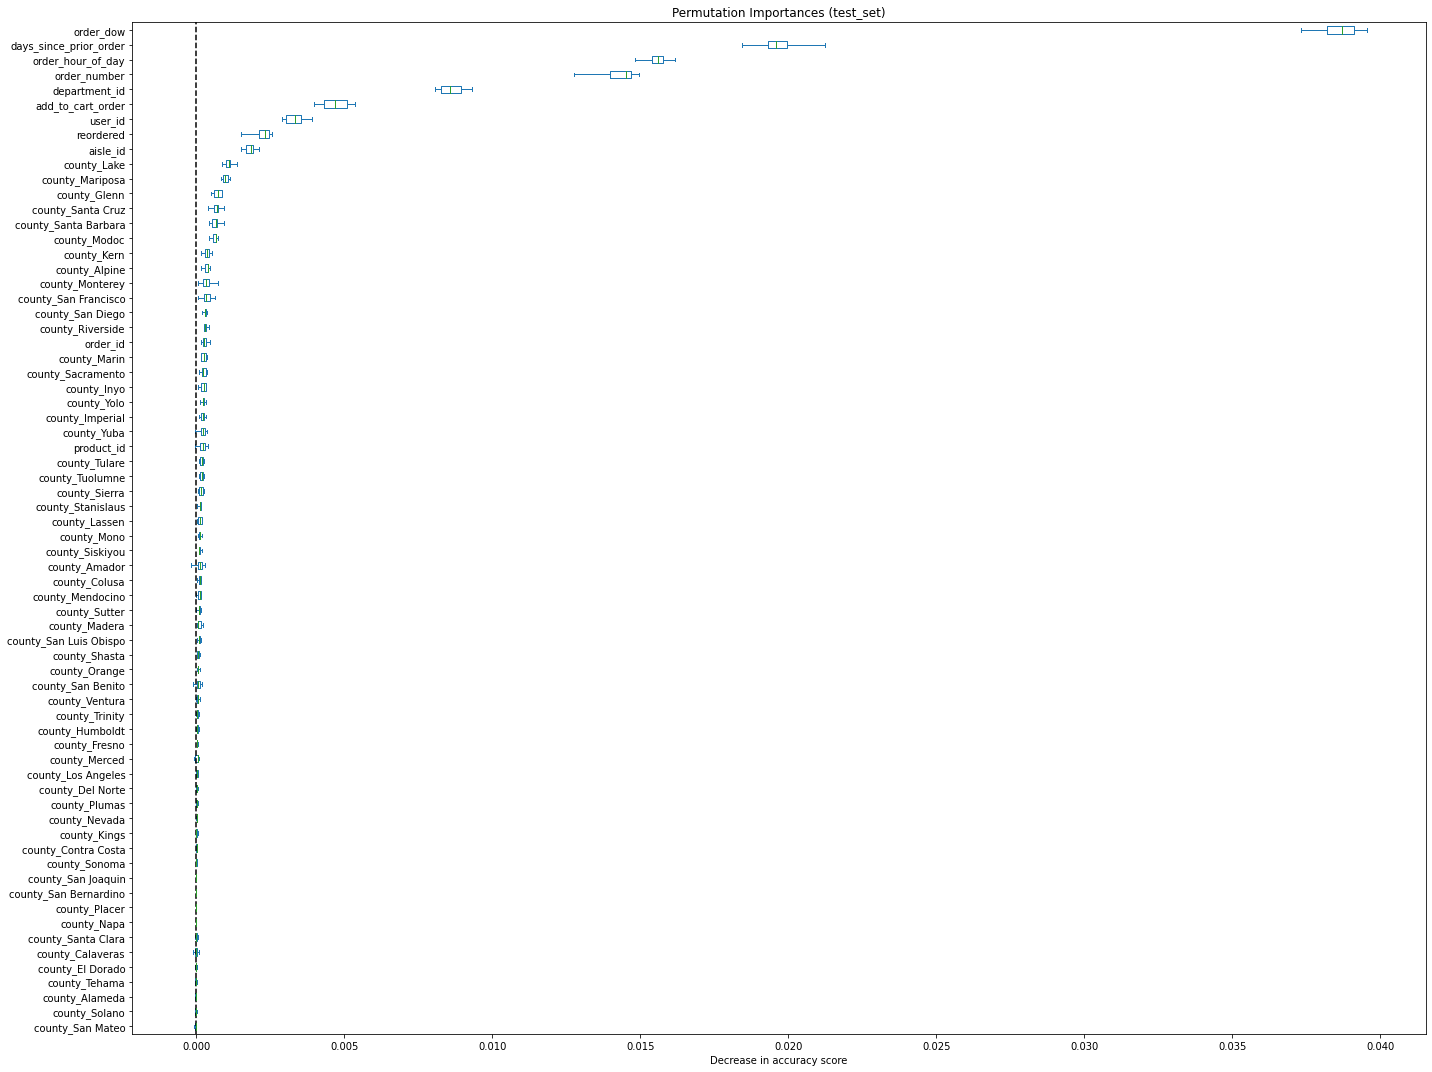

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_hgbc, X_test, y_test, n_repeats= 10, random_state= 0, n_jobs= -1)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
 result.importances[sorted_importances_idx].T,
 columns= X.columns[sorted_importances_idx]
)

ax= importances.plot.box(vert= False, whis= 10, figsize= (20, 15))
ax.set_title("Permutation Importances (test_set)")
ax.axvline(x= 0, color= "k", linestyle= "--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

##### **DTC**

In [ ]:
gs_crss_dtc = GridSearchCV(
 estimator= DecisionTreeClassifier(),
 param_grid= dict(min_samples_split= [2, 10, 20, 50, 100], max_depth= [1, 3, 5, 9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_dtc.best_params_} with acc: {gs_crss_dtc.best_score_}")

Best param: {'max_depth': 9, 'min_samples_split': 2, 'random_state': 0} with acc: 0.6153791267999122


In [ ]:
best_dtc = DecisionTreeClassifier(max_depth= 9, min_samples_split= 2, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_dtc.predict(X_train)
y_best_test_pred = best_dtc.predict(X_test)

print_evaluation("DTC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

DTC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.62265 |        0.44900 |    0.60626 |   490613 |       68
Test      0.61832 |        0.44142 |    0.60009 |   122654 |       68



In [ ]:
# 'user_tip_ratio': 0.9335026329367192
# 'order_dow': 0.031994586879281556
# 'order_hour_of_day': 0.015698835635160557
print(dict(zip(X.columns, best_dtc.feature_importances_)))

{'order_id': 0.019581176205294853, 'product_id': 0.002537565071532999, 'add_to_cart_order': 0.022761942309562227, 'reordered': 0.006659065878254095, 'user_id': 0.02214895472079787, 'order_number': 0.1447682936353831, 'order_dow': 0.26321289253051317, 'order_hour_of_day': 0.11834175897163453, 'days_since_prior_order': 0.31906231707003263, 'aisle_id': 0.0031052613953845994, 'department_id': 0.04841315012127472, 'county_Alameda': 0.0, 'county_Alpine': 0.002244993863614482, 'county_Amador': 0.0, 'county_Calaveras': 0.0015117222700695514, 'county_Colusa': 0.0, 'county_Contra Costa': 0.0007651771762174871, 'county_Del Norte': 0.0, 'county_El Dorado': 0.0, 'county_Fresno': 0.000432596391538689, 'county_Glenn': 0.0023329571095769734, 'county_Humboldt': 0.0, 'county_Imperial': 0.0008681458648554431, 'county_Inyo': 0.00020955951935235583, 'county_Kern': 0.0004655911828492815, 'county_Kings': 0.0, 'county_Lake': 0.002773278902561399, 'county_Lassen': 0.0006038669201519709, 'county_Los Angeles': 0